In [1]:
import open3d as o3d
from pyntcloud import PyntCloud
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

Before voxelisation we process point cloud by remove outliers. This step is justified beacuse

In [2]:
pcd = o3d.io.read_point_cloud("finalproject.ply")
#cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
#o3d.visualization.draw_geometries([cl])
#o3d.io.write_point_cloud("finalproject_wn.ply", cl)
pc = PyntCloud.from_file("finalproject.ply")
pcd_array = np.asarray(pc.points)
#sample = np.random.choice(pcd_array, size=(200,3,2))

In [8]:
voxelgrid.colors

In [5]:
voxelgrid_id = pc.add_structure("voxelgrid", size_x=10, size_y=10, size_z=10)
voxelgrid = pc.structures[voxelgrid_id]
voxels = voxelgrid.voxel_n

print("Number of voxels: ", len(voxels))
print("Voxel IDs: ", voxels)

# Voxels containing points
occupied_voxels = np.unique(voxelgrid.voxel_n)

# Visualize voxels
voxelgrid.plot(d=3, mode="density", cmap="hsv")

Number of voxels:  24134667
Voxel IDs:  [4622276 4622276 4622276 ... 9215864 9215864 9215864]


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(119.42081451416016, 350.7509536743164, 318.1…

In [9]:
pca = PCA(n_components=3)
all_voxel_info_tmp = []


for voxel in occupied_voxels:
    
    linearity ,planarity, scattering, omnivariance, sum_ev, anistropy, eigentropy, curvature_change, residual = 0,0,0,0,0,0,0,0,0
    ev=[]
    
    
    tmp = np.where(voxelgrid.voxel_n == voxel) #Gets all points that are in voxel
    voxel_points = pcd_array[tmp] #Gets all points that are in voxel
    
    vmax = np.array([voxel_points[:,0].max(), voxel_points[:,1].max(), voxel_points[:,2].max()])
    vmin = np.array([voxel_points[:,0].min(), voxel_points[:,1].min(), voxel_points[:,2].min()])
    vmean = np.array([voxel_points[:,0].mean(), voxel_points[:,1].mean(), voxel_points[:,2].mean()])
    num_points = len(voxel_points)
    
    if (len(tmp[0])) > 99:
        sample = np.random.choice(tmp[0], 100, replace = False)
    for point in sample:
        residual += abs(pcd_array[point][2] -vmean[2]) #Diff in z
    
    residual = residual / 100
    
    if (len(tmp[0])) > 2: #minimum number of points to do PCA=
        pca.fit(voxel_points[:,:3])
        ev = pca.explained_variance_ratio_
        EV = pca.explained_variance_
        
        # Shape features
        l1, l2, l3 = ev
        L1,L2,L3 =EV
        linearity = (l1 - l2) / l1
        planarity = (l2 - l3) / l1  
        scattering = l3 / l1 
        omnivariance = (l1 * l2 * l3) ** (1 / 3) 
        sum_ev = L1 + L2 + L3 
        anistropy = (l1 - l3) / l1 
        curvature_change = L1 / sum_ev
        zmax = abs(vmax[2] - vmin[2])
        
        
        #z_diff = abs(vmax[2] - vmin[2])

        if(0 not in ev):
            eigentropy = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))


        
        
    res = np.array([voxel, linearity ,planarity ,scattering, omnivariance, sum_ev,anistropy, eigentropy, curvature_change, num_points, residual, zmax])
    all_voxel_info_tmp.append(res)
        

            

        

In [12]:
#res = voxel, ev, xyzmax, xyzmin, xyzmean, num_points
arr = np.asarray(all_voxel_info_tmp)
# intialise data of lists. 
# Create DataFrame use id as index
df = pd.DataFrame(arr) 
#df.set_index(0)
df.columns = ['voxel_id', 'linearity', 'planarity', 'scattering', 'omnivariance', 'sum_ev', 'anistropy', 'eigentropy', 'curvature_change', 'num_points', 'residual','z_diff_max']
df = df.astype({"voxel_id": int, 'num_points':int})
df = df.dropna()
num_voxels = len(df)
#df = df.mask(df.eq('NoneType')).dropna()
df = df.set_index('voxel_id')

In [13]:
features = set(['linearity', 'planarity', 'scattering', 'omnivariance', 'sum_ev', 'anistropy', 'curvature_change', 'num_points', 'residual','z_diff_max'])

In [ ]:
fig, axs = plt.subplots(2, 2, sharex = True)
axs[0, 0].plot(df['binned'].value_counts(), labels)
axs[0, 0].set_title('Linearity')
axs[0, 1].plot(df['binned'].value_counts(), labels, 'tab:orange')
axs[0, 1].set_title('Planerity]')
axs[1, 0].plot(df['binned'].value_counts(), labels, 'tab:green')
axs[1, 0].set_title('Omnivariance')
axs[1, 1].plot(df['binned'].value_counts(), labels, 'tab:red')
axs[1, 1].set_title('Axis [1,1]')

for ax in axs.flat:
    ax.set(xlabel='percentile voxels', ylabel='value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

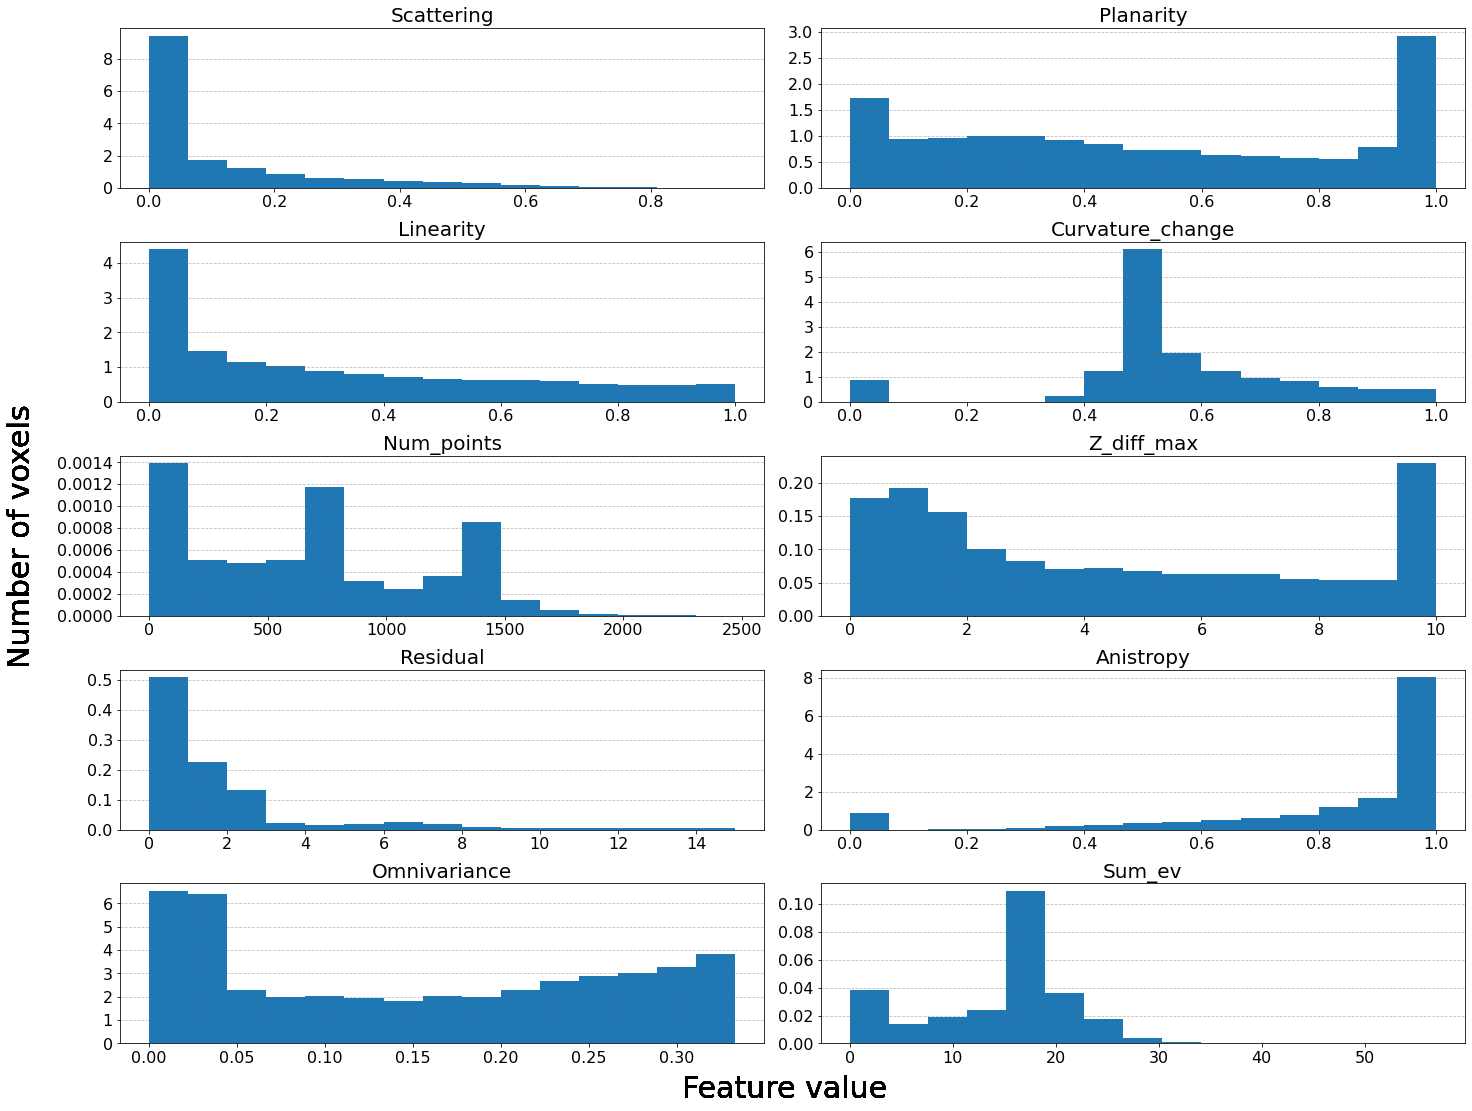

In [19]:
labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


# initialise the figure
fig, axes = plt.subplots(5, 2)

# adjust the size of the figure so all subplots fit inside
fig.set_figheight(15)
fig.set_figwidth(20)

# set title for the figure
#fig.suptitle("Feature voxel Distributions", ha = "left", x=0.1, y=0.9, fontsize = 30)

# plot each of the different crime type on their own subplot
for index, feature in enumerate(features):
    
    
    # get the right subplot
    
    axis = axes[index//2, index%2]
    index +=1
    
    # prepare the data'
    
    if (feature == "residual") :
         bins = np.linspace(0, 15, 16)

    else:
        bins = np.linspace(df[feature].min(),df[feature].max(), 16)
        
        
        
   # elif(feature =="residual"):
   #     bins = np.linspace(0,15, 16)
   # elif(feature =="curvature_change"):
   #     bins = np.linspace(0,0.5, 16)
            
    
        
    data = df[feature]
    #out = pd.cut(df[feature], bins=bins, include_lowest=True)

    # plot the data
    #axis.bar(out.value_counts(sort=False), df[feature].max())
    axis.hist(df[feature], bins = bins)
    
    # add trimmings to the plot
    subplot_title = feature.capitalize()
    axis.grid(b=True, axis="y", which='major', color='#666666', linestyle='--', alpha=0.4)
    axis.title.set_text("{}".format(subplot_title))
    fig.text(-0.02, 0.5, "Number of voxels", verticalalignment="center", rotation = 90, fontsize = 30);
    fig.text(0.52, -0.02, "Feature value", horizontalalignment="center", rotation = 0, fontsize = 30);

    
    
    # adjust the text size on the plot
    axis.title.set_size(20)
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)     
    for tick in axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 

# remove the first empty plot


fig.tight_layout()

Now we have binned the voxels based on feature values and have a overview due to df.describe().
With the data-analysis we can start the actual classification step. The method of trail and error was done to achive the scalar values used for classifying. To understand the whole process it is helpful to look at each feature 

In [25]:
df.describe().T
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,linearity,planarity,scattering,omnivariance,sum_ev,anistropy,eigentropy,curvature_change,num_points,residual,z_diff_max
linearity,1.000000,-0.658896,-0.064967,0.076365,-0.305002,0.283372,-0.207085,0.808419,-0.560555,0.010184,-0.098229
planarity,-0.658896,1.000000,-0.315586,-0.232084,0.392508,0.534687,0.319638,-0.116210,0.624531,-0.401327,-0.330970
scattering,-0.064967,-0.315586,1.000000,0.822578,0.459781,-0.475318,0.661228,-0.194761,0.216800,-0.083365,0.725671
omnivariance,0.076365,-0.232084,0.822578,1.000000,0.460667,-0.210092,0.787466,-0.004777,0.159160,-0.185832,0.767467
sum_ev,-0.305002,0.392508,0.459781,0.460667,1.000000,0.157766,0.695539,-0.023176,0.652267,-0.438001,0.438732
anistropy,0.283372,0.534687,-0.475318,-0.210092,0.157766,1.000000,0.174864,0.760014,0.166484,-0.500205,-0.532297
eigentropy,-0.207085,0.319638,0.661228,0.787466,0.695539,0.174864,1.000000,0.037689,0.515033,-0.477123,0.474348
curvature_change,0.808419,-0.116210,-0.194761,-0.004777,-0.023176,0.760014,0.037689,1.000000,-0.203482,-0.326837,-0.331000
num_points,-0.560555,0.624531,0.216800,0.159160,0.652267,0.166484,0.515033,-0.203482,1.000000,-0.378103,0.130194
residual,0.010184,-0.401327,-0.083365,-0.185832,-0.438001,-0.500205,-0.477123,-0.326837,-0.378103,1.000000,0.049294


In [15]:
def colorize(category):
    color = []
    #color = [1, 0, 0] 
    if(category == "tree"):
        color = [0, 102, 0]
        
    if(category =='terrain'):
        color = [153, 76, 0]
        
    if (category =='roof'):
        color =[51, 51, 255]

        
    return np.asarray(color)
        
    

In [ ]:
df['color'] = df['category'].apply(colorize)
voxel_colors = df['color'].to_numpy()
#voxelgrid.colors = voxel_colors
#voxelgrid.plot(d=3, mode="density", cmap="hsv")

In [16]:
def classify_voxel(row):
    class_type = []    
    
    linearity = row[0]
    planarity = row[1]
    omnivariance= row[2]
    scattering = row[3]
    sum_ev= row[4]
    anistropy = row[5]
    eigentropy = row[6]
    curvature_change = row[7]
    num_points = row[8]
    residual = row[9]
    z_diff_max = row[10]

    
    # Water body -> Ingen returns? Vanskelig å se på
    
    # Low vegiation -> low residual & high scattering?, altså lav 
    
    # Roads -> high planarity, low scattering low linearity, high anistropy?
    
    
    
    
    if (linearity > planarity):
        class_type = "tree"
    
    else:
        if(residual > 3):
            class_type = "roof"
        else:
            class_type = "terrain"
                
    
    return class_type


In [ ]:
df['category'] = df.apply(classify_voxel, axis=1)
df

Here begins the actual segmentation part. Now we have voxelized the pointcloud and the result is 475999 occupied voxels. 

Now each entry in all_voxel_info_tmp -> [voxel number, [eigenvalues]]. But we want to use more information than just the result from the PCA. We can take advantage of knowledge as density, min-coords, max-coords and means. Thus we add three new fields as  -> density : dtype float, [min-coords], [max-coords], mean : float. 
Remember that this will be the cell-block above will be the main method of this project. Smarter to just do all data-processing in this loop. 

In [ ]:
all_trees = []
for current_voxel in terrain_list:
    points = np.where(voxelgrid.voxel_n == current_voxel)
    all_trees.append(points)
    
    

In [ ]:
flatted = [item for sublist in all_trees for item in sublist]
flatted_2 = [item2 for sublist2 in flatted for item2 in sublist2]
flatted_2

In [ ]:
trees = pcd.select_by_index(flatted_2)
trees.paint_uniform_color([1.0, 0, 0])
o3d.io.write_point_cloud("tree_test.ply", [trees])

In [ ]:
terrain_df = df.loc[df['category'] == "terrain"]
terrain_list = terrain_df.index.to_numpy()
test = np.where(voxelgrid.voxel_n == terrain_list[6])
coordinates = pcd_array[test[0]]
coordinates

In [ ]:

tmp = np.where(voxelgrid.voxel_n == voxel) #Gets all points that are in voxel
voxel_points = pcd_array[tmp] #Gets all points that are in voxel